# Detecting Oil tanks

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import shutil
from tensorflow import keras
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
import matplotlib.pyplot as plt

In [2]:
SPLIT_RATIO = 0.2
SPLIT_RATIO_TEST = 0.1
BATCH_SIZE = 4

# Prepare data

In [3]:
json_file_path = '/Users/adnan/Documents/oil-tanks-dataset/labels.json'

In [4]:
# Open and read the JSON file
with open(json_file_path, 'r') as f:
    json_data = json.load(f)

In [5]:
df = pd.DataFrame(json_data)
df

,id,file_name,label
0,0,01_0_0.jpg,Skip
1,1,01_0_1.jpg,Skip
2,2,01_0_2.jpg,Skip
3,3,01_0_3.jpg,Skip
4,4,01_0_4.jpg,"{'Tank': [{'geometry': [{'x': 438, 'y': 254}, ..."
...,...,...,...
9995,9995,100_9_5.jpg,Skip
9996,9996,100_9_6.jpg,Skip
9997,9997,100_9_7.jpg,Skip
9998,9998,100_9_8.jpg,Skip


In [6]:
unskips = df[df['label'] !='Skip']

In [7]:
# Extract value from nested JSON
def extract_value(nested_json):
    geometries = []
    for item in nested_json:
        current_item = nested_json[item]
        #print(current_item)
        for geometry in current_item:
            geometries.extend(geometry['geometry'])
    return {'geometry': geometries}

def extract_label(nested_json):
    for item in nested_json:
        return item
    
# Create new column based on nested JSON
unskips['geometries'] = unskips['label'].apply(extract_value)

unskips['label'] = unskips['label'].apply(extract_label)

/var/folders/2c/z33xthlj48scfw_3hj1c76sh0000gn/T/ipykernel_6593/1700583073.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unskips['geometries'] = unskips['label'].apply(extract_value)
/var/folders/2c/z33xthlj48scfw_3hj1c76sh0000gn/T/ipykernel_6593/1700583073.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unskips['label'] = unskips['label'].apply(extract_label)


In [8]:
df = unskips
label_value = 'None'
filtered_rows = df[df['label'] !=label_value]
df = filtered_rows
df.to_csv('old_output.csv', index=False)
df

,id,file_name,label,geometries
4,4,01_0_4.jpg,Tank,"{'geometry': [{'x': 438, 'y': 254}, {'x': 438,..."
21,21,01_2_1.jpg,Tank,"{'geometry': [{'x': 103, 'y': 310}, {'x': 103,..."
22,22,01_2_2.jpg,Tank,"{'geometry': [{'x': 24, 'y': 299}, {'x': 24, '..."
23,23,01_2_3.jpg,Tank,"{'geometry': [{'x': 52, 'y': 308}, {'x': 52, '..."
24,24,01_2_4.jpg,Tank,"{'geometry': [{'x': 153, 'y': 416}, {'x': 153,..."
...,...,...,...,...
9861,9861,99_6_1.jpg,Floating Head Tank,"{'geometry': [{'x': 69, 'y': 450}, {'x': 69, '..."
9864,9864,99_6_4.jpg,Floating Head Tank,"{'geometry': [{'x': 19, 'y': 415}, {'x': 19, '..."
9871,9871,99_7_1.jpg,Floating Head Tank,"{'geometry': [{'x': 67, 'y': 56}, {'x': 67, 'y..."
9946,9946,100_4_6.jpg,Floating Head Tank,"{'geometry': [{'x': 30, 'y': 337}, {'x': 30, '..."


In [9]:
def convert_boxes(data):
    geometry = data['geometry']
    # Group points into sets of four to form bounding boxes
    bounding_boxes = [
        geometry[i:i+4] for i in range(0, len(geometry), 4)
    ]
    all_boxes = []
    # Print each bounding box
    for i, box in enumerate(bounding_boxes):
        xs = np.array([point['x'] for point in box])
        ys = np.array([point['y'] for point in box])
        x_min = xs.min()
        x_max = xs.max()
        y_min = ys.min()
        y_max = ys.max()
        #print(f"Bounding box {i+1}: (y_min={y_min}, x_min={x_min}, y_max={y_max}, x_max={x_max})")
        all_boxes.append([x_min, y_min, x_max, y_max])
    return all_boxes

def convert_bounding_boxes_to_tensor(bounding_boxes):
    bounding_boxes_tf = convert_boxes(bounding_boxes)
    #print(bounding_boxes_tf)
    return bounding_boxes_tf

df['geometries'] = df['geometries'].apply(convert_bounding_boxes_to_tensor)

In [10]:
def convert_label(label):
    # convert labels
    if label == 'Tank':
        return [1]
    elif label == 'Floating Head Tank':
             return [2]
    elif label == 'Tank Cluster':
             return [3]
df['label'] = df['label'].apply(convert_label)
df = df.dropna()
df.to_csv('final.csv', index=False)

df

,id,file_name,label,geometries
4,4,01_0_4.jpg,[1],"[[438, 254, 455, 271], [388, 259, 408, 279]]"
21,21,01_2_1.jpg,[1],"[[103, 310, 133, 334], [265, 315, 289, 338], [..."
22,22,01_2_2.jpg,[1],"[[24, 299, 82, 352], [151, 303, 209, 355], [27..."
23,23,01_2_3.jpg,[1],"[[52, 308, 111, 364]]"
24,24,01_2_4.jpg,[1],"[[153, 416, 214, 474]]"
...,...,...,...,...
9861,9861,99_6_1.jpg,[2],"[[69, 450, 159, 514]]"
9864,9864,99_6_4.jpg,[2],"[[19, 415, 97, 482]]"
9871,9871,99_7_1.jpg,[2],"[[67, 0, 158, 56]]"
9946,9946,100_4_6.jpg,[2],"[[30, 337, 74, 392], [31, 489, 74, 513]]"


In [11]:
def update_file_name(file_name):
    label = str(df[df['file_name'] == file_name]['label'].values[0][0])+'/'
    directory = '/Users/adnan/Documents/GitHub/automatic-spork/tank_detection/'
    file_path = directory+label+file_name
    
    return file_path

df['file_name'] = df['file_name'].apply(update_file_name)

df

/var/folders/2c/z33xthlj48scfw_3hj1c76sh0000gn/T/ipykernel_6593/2117235443.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['file_name'] = df['file_name'].apply(update_file_name)


,id,file_name,label,geometries
4,4,/Users/adnan/Documents/GitHub/automatic-spork/...,[1],"[[438, 254, 455, 271], [388, 259, 408, 279]]"
21,21,/Users/adnan/Documents/GitHub/automatic-spork/...,[1],"[[103, 310, 133, 334], [265, 315, 289, 338], [..."
22,22,/Users/adnan/Documents/GitHub/automatic-spork/...,[1],"[[24, 299, 82, 352], [151, 303, 209, 355], [27..."
23,23,/Users/adnan/Documents/GitHub/automatic-spork/...,[1],"[[52, 308, 111, 364]]"
24,24,/Users/adnan/Documents/GitHub/automatic-spork/...,[1],"[[153, 416, 214, 474]]"
...,...,...,...,...
9861,9861,/Users/adnan/Documents/GitHub/automatic-spork/...,[2],"[[69, 450, 159, 514]]"
9864,9864,/Users/adnan/Documents/GitHub/automatic-spork/...,[2],"[[19, 415, 97, 482]]"
9871,9871,/Users/adnan/Documents/GitHub/automatic-spork/...,[2],"[[67, 0, 158, 56]]"
9946,9946,/Users/adnan/Documents/GitHub/automatic-spork/...,[2],"[[30, 337, 74, 392], [31, 489, 74, 513]]"


In [12]:
# create ragged tensorts for cols
bbox = tf.ragged.constant(df['geometries'])
classes = tf.ragged.constant(df['label'])
image_paths = tf.ragged.constant(df['file_name'])


2024-06-30 19:28:21.636209: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-30 19:28:21.636256: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-30 19:28:21.636259: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-30 19:28:21.636295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-30 19:28:21.636314: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
# Create dataset
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

# Determine the number of validation/test samples
num_val = int(len(df) * SPLIT_RATIO)
num_test = int(len(df) * SPLIT_RATIO_TEST)
# Split the dataset into train and validation/test sets
val_data = data.take(num_val)
test_data = data.skip(num_val).take(num_test)
train_data = data.skip(num_val + num_test)

In [14]:
def load_image(image_path):
    # loads each image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # fetch and prepare the images and bounding boxes
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    print(len(bounding_boxes['boxes'].shape))
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [15]:
# Define the augmentations we want to apply.
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(512, 512), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

2


In [16]:
resizing = keras_cv.layers.Resizing(
    512, 512,
    bounding_box_format="xyxy",
    pad_to_aspect_ratio=True
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = test_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(BATCH_SIZE * 4)
test_ds = test_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

2
2


2024-06-30 19:28:23.538788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-06-30 19:28:24.023940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{function_node sequential_1_jittered_resize_1_map_while_body_1809}}{{node sequential_1/jittered_resize_1/map/while/map/while}}]]
2024-06-30 19:28:24.028315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{node sequential_1/random_flip_1/map/while/LoopCond/_20}}]]


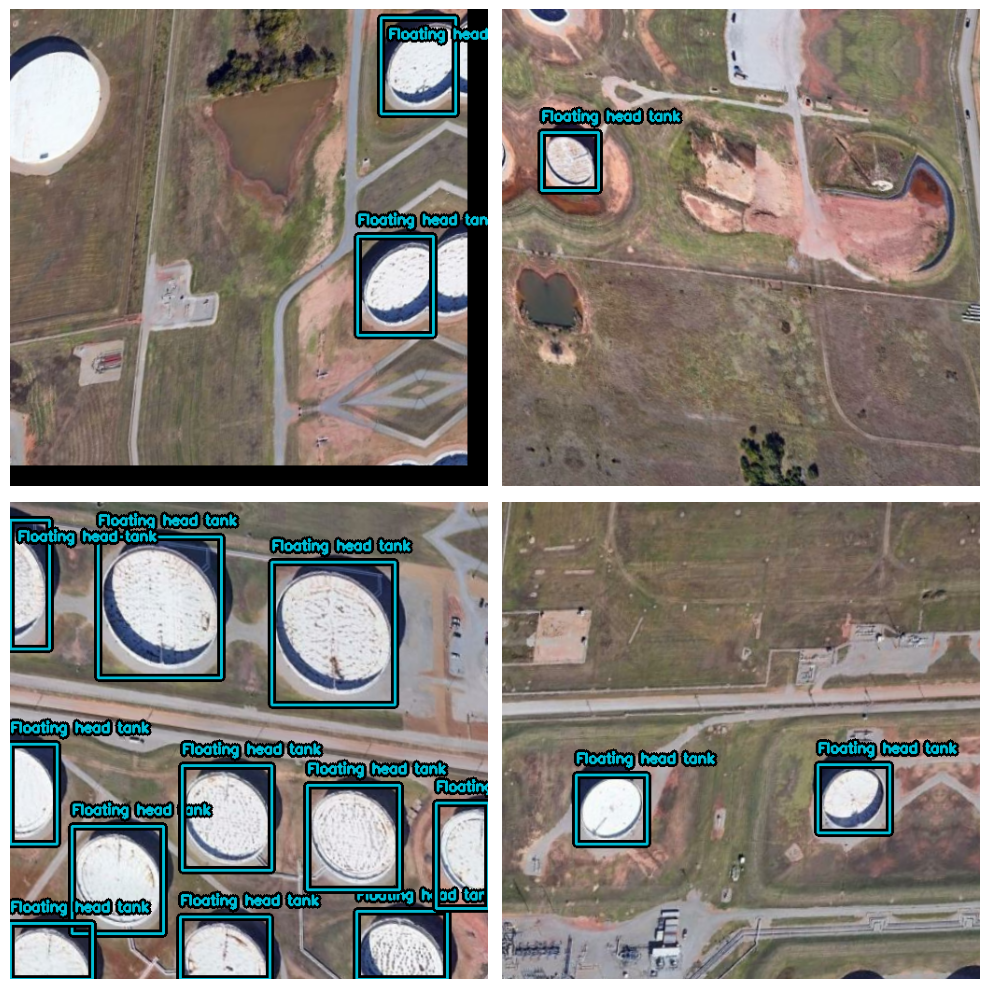

In [17]:
# Let's visualize the train set
class_mapping = {
    1: 'Tank',
    2: 'Floating head tank',
    3: 'Cluster tank'
}
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(190)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.5,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [18]:
# prepare our datasets for the model 
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# Set up and train model

In [19]:
# fetch pretrained model 
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    bounding_box_format="xyxy",
    num_classes=20, # it's pretrained with 20 classes
)

In [20]:
base_lr = 0.005 # set base learning rate
# define optimizer
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [21]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    val_ds.take(20), bounding_box_format="xyxy") # use the preset cocometrics.

In [22]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer
)
model.fit(
    train_ds.take(20), # just a demo, so we don't need whole dataset.
    # Running for 1 epoch since we're just demonstrating.
    epochs=1,
    verbose=1,
    callbacks=[coco_metrics_callback]
)

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 571ms/step


2024-06-30 19:33:57.602259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

# Predict on test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


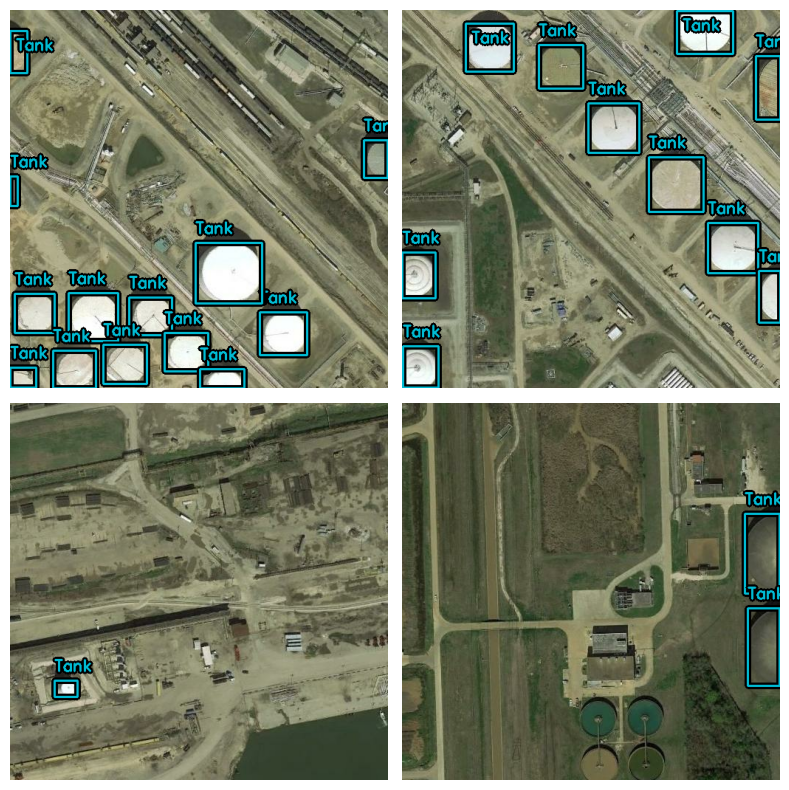

In [25]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(2)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )
    
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=test_ds, bounding_box_format="xyxy")    